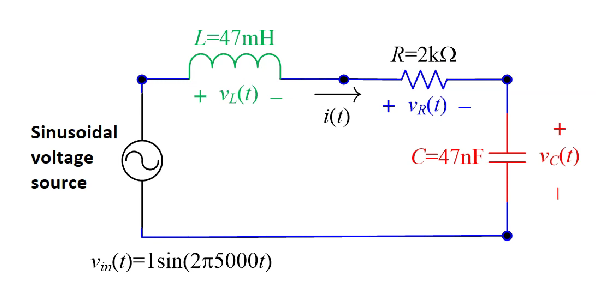

----------
Impedances
----------
Resistor Impedance =2k Ω
Capacitor Impedance = 0.00-677.26j Ω
Inductor Impedance = 0.00+1476.55j Ω
Alpha =21.28k rad/s
Omega_0 =21.28k rad/s
Damping ratio =1
-----------------
Series RLC circuit is critically damped
-----------------


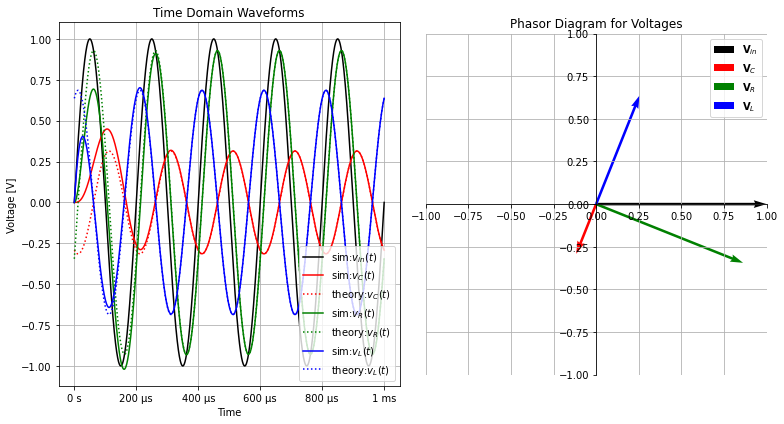

In [1]:
##*********************************************
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from matplotlib.pyplot import semilogx
from matplotlib import pyplot

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from engineering_notation import EngNumber

from matplotlib.ticker import EngFormatter

##*******************************************
circuit = Circuit('Series RLC Circuit')

Va=1@u_V
f= 5@u_kHz
Vo=0
Td=0
Df=0

circuit.SinusoidalVoltageSource(1, 'input', circuit.gnd,
                                amplitude=Va, frequency = f, offset
                                = Vo, delay = Td, damping_factor =Df)

# R = 4k for over damped, R = 2k for critically damped and R=500 for under damped
R1 = circuit.R(1, 'input', 'a', 2000@u_Ω)
L1 = circuit.L(1, 'a', 'out', 47@u_mH)
C1 = circuit.C(1, 'out', circuit.gnd, 47@u_nF)

steptime=0.1@u_us
finaltime = 5*(1/f)

##*************************************
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=steptime, end_time=finaltime)

##*************************************

time=np.array(analysis.time)
Vin = Va
Z_R = circuit.R1.resistance
Z_C = (1/(1j* 2*math.pi*f*circuit.C1.capacitance))
Z_L = 1j* 2*math.pi*f*circuit.L1.inductance

Z_T = Z_L+Z_R+Z_C

VL = (Z_L/Z_T)*Vin
VR = (Z_R/Z_T)*Vin
VC = (Z_C/Z_T)*Vin
vC= abs(VC)*np.sin(2*math.pi*f*time+np.angle(VC))
vR = abs(VR)*np.sin(2*math.pi*f*time+np.angle(VR))
vL = abs(VL)*np.sin(2*math.pi*f*time+np.angle(VL))

print ('----------')
print ('Impedances')
print ('----------')
print('Resistor Impedance ={} Ω'.format(EngNumber(float(Z_R))))
print('Capacitor Impedance = {:.2f} Ω'.format(Z_C))
print('Inductor Impedance = {:.2f} Ω'.format(Z_L))

alpha = float(circuit.R1.resistance/(2*circuit.L1.inductance))
omega0 = float(math.sqrt(1/(circuit.L1.inductance*circuit.C1.capacitance)))
damping_ratio = float(alpha/omega0)

print('Alpha ={} rad/s'.format(EngNumber(alpha)))
print('Omega_0 ={} rad/s'.format(EngNumber(omega0)))
print('Damping ratio ={}'.format(EngNumber(damping_ratio)))

if damping_ratio == 1:
    print('-----------------')
    print('Series RLC circuit is critically damped')
    print('-----------------')
elif damping_ratio > 1:
    print('-----------')
    print('Series RLC circuit is overdamped')
    print('------------')
else:
    print('-----------')
    print('Series RLC circuit is underdamped')
    print('-----------')
    

##********************************************

figure = plt.subplots(figsize=(11, 6))

axe = plt.subplot(121)
plt.title('Time Domain Waveforms')
plt.xlabel('Time')
plt.ylabel('Voltage [V]')
plt.grid()
formatter0 = EngFormatter(unit='s')
axe.xaxis.set_major_formatter(formatter0)

plot(analysis['input'], 'k')
plot(analysis['out'],'r')
plt.plot(time, vC,'r:')
plot(analysis['input']-analysis['a'],'g')
plt.plot(time, vR,'g:')
plot(analysis['a']-analysis['out'],'b')
plt.plot(time, vL,'b:')
plt.legend(('sim:$v_{in}(t)$','sim:$v_{C}(t)$', 'theory:$v_{C}(t)$',
            'sim:$v_{R}(t)$', 'theory:$v_{R}(t)$'
            ,'sim:$v_{L}(t)$', 'theory:$v_{L}(t)$'),loc='lower right')
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
cursor = Cursor(axe, useblit=True, color='red', linewidth=1)


##****************************

#figure = plt.subplots(figsize=(11, 6))
axe = plt.subplot(122)

plt.title('Phasor Diagram for Voltages')

axe.quiver(0, 0, float(Vin), 0,units='xy' ,scale=1,color='k')
axe.quiver(0, 0, np.array((np.real(VC))), np.array((np.imag(VC))),units='xy' ,scale=1, color='r')
axe.quiver(0, 0, np.array((np.real(VR))), np.array((np.imag(VR))),units='xy' ,scale=1, color='g')
axe.quiver(0, 0, np.array((np.real(VL))), np.array((np.imag(VL))),units='xy' ,scale=1, color='b')

plt.grid()
axe.set_aspect('equal')
axe.spines['left'].set_position('zero')
axe.spines['right'].set_color('none')
axe.spines['bottom'].set_position('zero')
axe.spines['top'].set_color('none')

limit = max(float(Va),np.amax(abs(VC)),np.amax(abs(VR)),np.amax(abs(VL)))
plt.xlim(-limit,limit)
plt.ylim(-limit,limit)
plt.legend(('$\mathbf{V}_{in}$','$\mathbf{V}_{C}$', '$\mathbf{V}_{R}$', '$\mathbf{V}_{L}$'))

plt.tight_layout()
plt.show()